In [ ]:
import uuid
from langgraph.store.memory import InMemoryStore
in_memory_store = InMemoryStore()

In [ ]:
# Namespace for the memory to save
user_id = "1"
namespace_for_memory = (user_id, "memories")

# Save a memory to namespace as key and value
key = str(uuid.uuid4())

# The value needs to be a dictionary  
value = {"food_preference" : "I like pizza"}

# Save the memory
in_memory_store.put(namespace_for_memory, key, value)

In [ ]:
# Search 
memories = in_memory_store.search(namespace_for_memory)
type(memories)

In [ ]:
# Metatdata 
memories[0].dict()

In [ ]:
# The key, value
print(memories[0].key, memories[0].value)

In [ ]:
# Get the memory by namespace and key
memory = in_memory_store.get(namespace_for_memory, key)
memory.dict()

## Case Study

In [20]:
from langchain_groq import ChatGroq
model = ChatGroq(temperature=0, model_name= "llama-3.1-8b-instant")

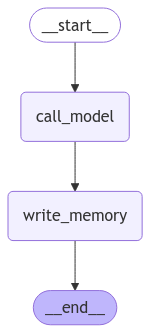

In [40]:
from IPython.display import Image, display

from langgraph.store.memory import InMemoryStore
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.base import BaseStore

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables.config import RunnableConfig

# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user. 
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

# Create new memory from the chat history and any existing memory
CREATE_MEMORY_INSTRUCTION = """"You are collecting information about the user to personalize your responses.

Chat History:
{memory}

INSTRUCTIONS:
1. Review the chat history above carefully
2. Identify new information about the user, such as:
   - Personal details (name, location)
   - Preferences (likes, dislikes)
   - Interests and hobbies
   - Past experiences
   - Goals or future plans
3. Merge any new information with existing memory
4. Format the memory as a clear, bulleted list
5. If new information conflicts with existing memory, keep the most recent version

Remember: Only include factual information directly stated by the user. Do not make assumptions or inferences.

Based on the chat history below above, please update the existing memory:


"""

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memory from the store and use it to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memory", user_id)
    key = "user_memory"
    existing_memory = store.get(namespace, key)

    # Extract the actual memory content if it exists and add a prefix
    if existing_memory:
        # Value is a dictionary with a memory key
        existing_memory_content = existing_memory.value.get('memory')
    else:
        existing_memory_content = "No existing memory found."

    # Format the memory in the system prompt
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=existing_memory_content)
    
    # Respond using memory as well as the chat history
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])
    print(f">>> response: {response}")

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and save a memory to the store."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve existing memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")
    print(f">>> existing_memory: {existing_memory}")
        
    # Extract the memory
    if existing_memory:
        existing_memory_content = existing_memory.value.get('memory')
    else:
        existing_memory_content = "No existing memory found."

    # Format the memory in the system prompt
    system_msg = CREATE_MEMORY_INSTRUCTION.format(memory=existing_memory_content)
    new_memory = model.invoke([SystemMessage(content=system_msg)]+state['messages'])
    print(f">>> new memory: {new_memory}")

    # Overwrite the existing memory in the store 
    key = "user_memory"

    # Write value as a dictionary with a memory key
    store.put(namespace, key, {"memory": new_memory.content})
    print(f">>> Saved Memory: {new_memory.content}")

# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)

builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [41]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi, my name is kim")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is kim
>>> response: content="Nice to meet you, Kim. I don't have any prior memory of our interactions, so this is the start of our conversation. How can I assist you today?" additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 35, 'prompt_tokens': 86, 'total_tokens': 121, 'completion_time': 0.046666667, 'prompt_time': 0.005378299, 'queue_time': 0.010187871000000001, 'total_time': 0.052044966}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f66ccb39ec', 'finish_reason': 'stop', 'logprobs': None} id='run-2bceaf99-549f-47f0-8802-5bc57c4ae18b-0' usage_metadata={'input_tokens': 86, 'output_tokens': 35, 'total_tokens': 121}
================================== Ai Message ==================================

Nice to meet you, Kim. I don't have any prior memory of our interactions, so this is the start of our conversation. How can I assist you today?
>>> existing

In [42]:
# User input 
input_messages = [HumanMessage(content="I like to bike around Seoul")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to bike around Seoul
>>> response: content="Seoul is a great city to explore by bike. I've learned that you're interested in biking around Seoul, so I can provide you with some recommendations. Have you considered visiting the Cheonggyecheon Stream, which is a popular spot for cycling and offers a scenic route through the city? Or perhaps you'd like to explore the Seoul Bike Path, which is a 700km network of bike lanes and paths that crisscross the city?" additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 92, 'prompt_tokens': 131, 'total_tokens': 223, 'completion_time': 0.122666667, 'prompt_time': 0.014821235, 'queue_time': 0.001923546, 'total_time': 0.137487902}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_9cb648b966', 'finish_reason': 'stop', 'logprobs': None} id='run-a4eed400-4c06-4662-9415-9bce34071b74-0' usage_metadata={'input_tokens': 131, 'output

In [37]:
thread = {"configurable": {"thread_id": "1"}}
state = graph.get_state(thread).values
for m in state["messages"]: 
    m.pretty_print()

================================ Human Message =================================

Hi, my name is kim
================================== Ai Message ==================================

Nice to meet you, Kim. I don't have any prior memory of our interactions, so this is the start of our conversation. How can I assist you today?
================================ Human Message =================================

I like to bike around Seoul
================================== Ai Message ==================================

Seoul is a great city to explore by bike. I've learned that you're interested in biking around Seoul, so I can provide you with some recommendations. Have you considered visiting the Cheonggyecheon Stream, which is a popular spot for cycling and offers a scenic route through the city? Or perhaps you'd like to explore the Seoul Bike Path, which is a 700km network of bike lanes and paths that crisscross the city?


In [9]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.search(namespace)
print(existing_memory)
existing_memory[0].dict()

{'value': {'memory': ''},
 'key': 'user_memory',
 'namespace': ['memory', '1'],
 'created_at': '2024-11-23T10:23:55.559394+00:00',
 'updated_at': '2024-11-23T10:23:57.437683+00:00'}

In [10]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")
print(existing_memory)
existing_memory.dict()

{'value': {'memory': ''},
 'key': 'user_memory',
 'namespace': ['memory', '1'],
 'created_at': '2024-11-23T10:23:55.559394+00:00',
 'updated_at': '2024-11-23T10:23:57.437683+00:00'}

In [ ]:
# We supply a user ID for across-thread memory as well as a new thread ID
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi! Where would you recommend that I go biking?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()